In [1]:
import bql
import numpy as np
from IPython.display import display, clear_output
import pandas as pd
import time 
import datetime
from ipywidgets import *
from bqplot import *
from bqplot.interacts import *

bq = bql.Service()
d = bq.data
f = bq.func
u = bq.univ

fi_idx = ['CBU7 LN Equity', 'USTY FP Equity', 'IGIL LN Equity', 'IDTP LN Equity', 'USIG US Equity', 'EMB US Equity', 'HYG US Equity',
          'LQDE LN Equity', 'FLOA LN Equity', 'IDTM LN Equity', 'IDTL LN Equity']

In [2]:
# INPUTS ###############

index_to_replicate = 'HFRIFOF Index'

start_date = datetime.datetime(2005,1,1)
end_date = datetime.datetime(2018,12,31)

In [3]:
#The fund inception of some ETFs it's too close to crrent days, so to make the analysis we will asume that these ETFs replicate exactly the underlying indexes.
#Due to this hypothesis, the time series are going to be analyzed with the underlying indexes.

etf_under_idx = d.fund_benchmark()

request = bql.Request(u.list(fi_idx), {'UND_IDX': etf_under_idx})
res = bq.execute(request)
undr_fi_idx = [undr +' Index' for undr in list(res[0].df()['UND_IDX'])]

In [4]:
######################  MAIN  ######################

index_universe = [index_to_replicate] + undr_fi_idx

# Compute the correlation matrix

price = d.px_last(start = start_date, end = end_date, per = 'M', fill='prev', currency = 'USD')
price = (100*price)/f.first(price) # Normalize each data series as in Percentage Appreciation but adds an offset of 100 (SAME METHOD WHEN COMPARING TWO SERIES IN GP<GO> AND NORMALIZING)

# price = f.znav(f.pct_diff(f.zscore(price)))/100
# price = 1-f.cumprod(price + 1) #We calculate the z_score of the price and from that z_score we see the cumulative total return to get the correlation

base_price = f.value(price, u.list(index_universe[0]))
correlation = f.corr(base_price, price)
correlation = f.dropna(correlation, REMOVE_ID =True)['value']

request = bql.Request(u.list(undr_fi_idx), {'CORRELATION': correlation}, preferences={'currencycheck':'ignore'}) #There's an error with de currencies of these tickers. This way we "solve" the issue
res = bq.execute(request)
data_mat = res[0].df().reset_index()

# Sort by Correlation
filtered_data_mat = data_mat.sort_values(by = ['CORRELATION'], ascending = False)

# Get the cumulative performance

for i in range(len(index_universe)): #We're doing this to get the DF in a way that the columns are the assets and the rows months (in some cases it's difficult to make the monthly alineation, this is why we develop this code)
    request = bql.Request(index_universe[i], {index_universe[i]: price}, preferences={'currencycheck':'ignore'}) #There's an error with de currencies of these tickers. This way we "solve" the issue
    res = bq.execute(request)
    
    asset = res[0].df()
    asset = pd.DataFrame({index_universe[i]: asset[index_universe[i]].tolist(), 'DATE': asset['DATE'].tolist()}, index= list(range(len(asset))))
    
    year_list = pd.DatetimeIndex(asset['DATE']).year.tolist()
    month_list = pd.DatetimeIndex(asset['DATE']).month.tolist()
    date_list = []
    for j in range(len(year_list)):
        date_list += [str(year_list[j]) + '-' + str(month_list[j])]
    asset['aux_date'] = date_list    
    
    if i == 0:
        matrix = asset.copy(deep=True)
    else :
        asset = asset.drop(['DATE'], axis=1)
        matrix = pd.merge(matrix, asset, how='left', on=['aux_date', 'aux_date'])
        
aux_matrix = matrix[index_universe]

FIRST WE MEASUERE THE CORRELATIONS BETWEEN THE ASSETS AND THE INDEX

In [5]:
x_bar = filtered_data_mat['ID'].tolist()
y_bar = filtered_data_mat['CORRELATION'].tolist()

xs = OrdinalScale()
ys = LinearScale()
sc = ColorScale(mid=0.0)

bar = Bars(x=x_bar, y=y_bar, scales={'x': xs, 'y': ys, 'color': sc}, color=y_bar, padding=0.5)

#To put names it's necessary the attribute names and the scatter plot has it. in order to see only the bars, the opacity of the scatter is going to be 0
# Changing the marker as 
sc_x = LinearScale()
sc_y = LinearScale()

scatt = Scatter(x=x_bar, y=y_bar, names=np.array(y_bar), scales={'x': xs, 'y': ys})

xax = Axis(scale=xs, tick_rotate=-45)
yax = Axis(scale=ys, orientation='vertical', tick_format='0.0%', grid_lines='solid')

plot = Figure(marks=[bar, scatt], axes=[xax, yax])
plot.layout.width = '1500px'
plot

Figure(axes=[Axis(scale=OrdinalScale(), tick_rotate=-45), Axis(orientation='vertical', scale=LinearScale(), ti…

WE SEE THE CONNECTIONS BETWEEN THE ASSETS AND THE INDEX WITH THE DENDROGRAM OF THE CORRELATION MATRIX

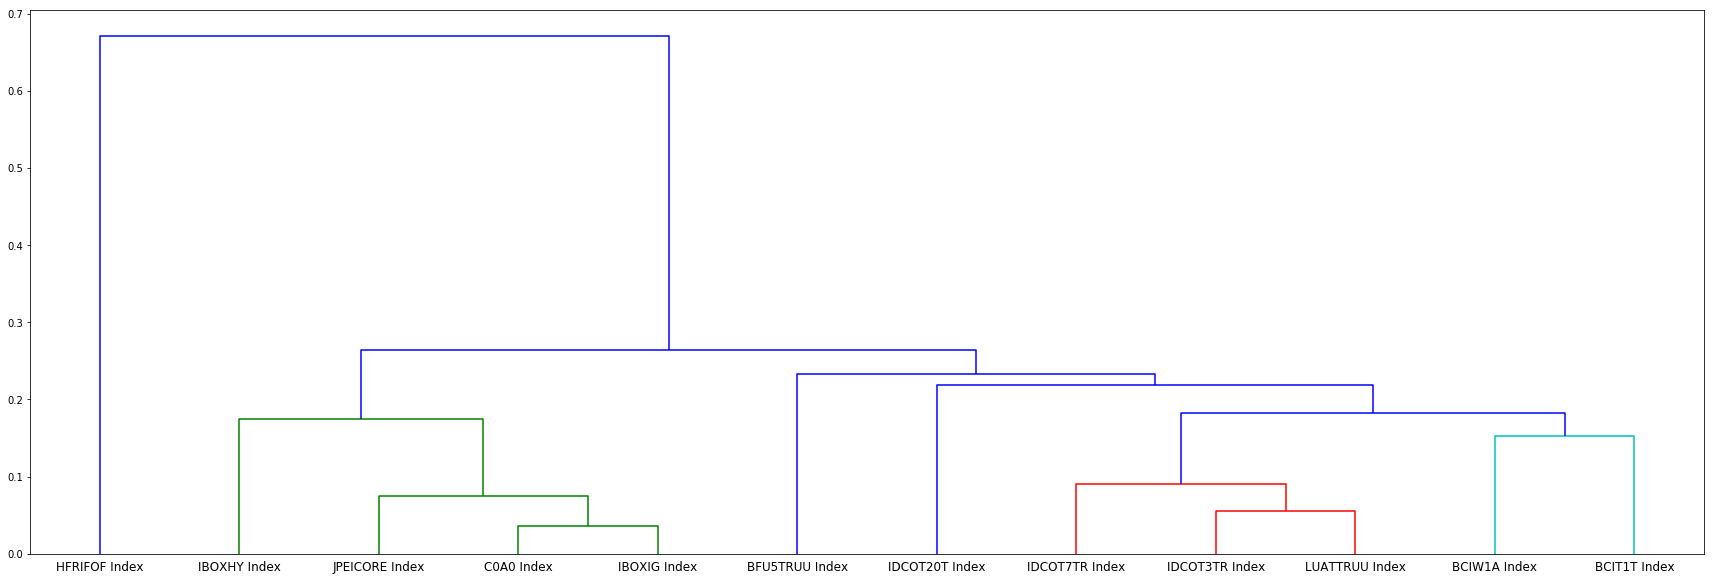

In [14]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

def correlDist(corr):
    dist = ((1-corr)/2)**0.5
    return dist

Correlations = aux_matrix.corr(method ='pearson')
Z = linkage(correlDist(Correlations))

max_d = 0.18

plt.figure(figsize=(30, 10), facecolor='w')
dendrogram(Z, labels = index_universe, color_threshold = max_d)
plt.show()

IN ORDER TO KNOW THE IMPORTANCE (WEIGHT) OF EACH ASSET AS A CHARACTERISTIC OF THE INDEX, WE PERFORM A LASSO REGRESSION (IN THIS CASE, WE DON'T USE A RIDGE REGRESSION BECAUSE THE DATA IS LESS CORRELATED)

In [7]:
from sklearn import linear_model

#We have to transform the data to give the correcto input for the ridge regression function
X = []
for i in range(len(aux_matrix)):
    X.append(np.array(aux_matrix.iloc[i][undr_fi_idx].tolist()))
X = np.array(X)
y = np.array(aux_matrix[index_universe[0]])
#############

list_alphas = np.arange(0.0001, 0.5, 0.0001)
list_fi = undr_fi_idx

weights = []
for coef_alpha in list_alphas:
    model = linear_model.Lasso(alpha=coef_alpha).fit(X,y)    
    weights.append(model.coef_)
    
list_weights= []
for i in range(len(list_fi)):
    aux_weight = []
    for ii in range(len(list_alphas)):
        aux_weight += [weights[ii][i]]
    
    list_weights += [aux_weight]
    

# Calculate the area of the curve in absolute terms
ridge_area = []
for i in range(len(list_fi)):
    ridge_area += [abs(sum(list_weights[i]))]
    
ridge_area = np.array(ridge_area)

#We will use this data mat when generating the scores to rack the assets
ridge_area_data_mat = pd.DataFrame(data = {'ID': list_fi, 'Ridge': ridge_area})

C:\blp\BQuant\environments\bqnt-1.17.1\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [8]:
x_lg = LogScale()
y_sc = LinearScale()

line = Lines(x=-list_alphas, y=list_weights, scales={'x': x_lg, 'y': y_sc}, display_legend=True, labels=list_fi)

ax_x = Axis(scale=x_lg, label='Alpha')
ax_y = Axis(scale=y_sc, orientation='vertical', label = 'Pesos')

plot = Figure(marks=[line], axes=[ax_x, ax_y], legend_location='top-left')
plot.layout.width = '1500px'
plot

Figure(axes=[Axis(label='Alpha', scale=LogScale()), Axis(label='Pesos', orientation='vertical', scale=LinearSc…

FINALLY WE MAKE A PCA TO CONTRAST ALL THIS RESULT IN ORDER TO CONFIRM THE ASSET SELECTION

In [9]:
from sklearn.decomposition import PCA

# The first step is to apply the difference between the series of the assets and the index
aux_matrix2 = aux_matrix.copy(deep=True)
aux_matrix2 = aux_matrix2[list_fi]
for eq in list_fi:
    aux_matrix2[eq] = aux_matrix2[eq] - aux_matrix[index_universe[0]] 

#Then we have to transform the data as in the Ridge regression
X = []
for i in range(len(aux_matrix2)):
    X.append(np.array(aux_matrix2.iloc[i][list_fi].tolist()))
X = np.array(X)
#############

pca = PCA(n_components=len(list_fi))
pca.fit(X)

x_bar = ['PC']*len(list_fi)
for i in range(len(list_fi)):
    x_bar[i] = x_bar[i] + str(i+1)

xs = OrdinalScale()
ys = LinearScale()
sc = ColorScale(mid=0.0)

bar = Bars(x=x_bar, y=pca.explained_variance_ratio_, scales={'x': xs, 'y': ys, 'color': sc}, color=y_bar, padding=0.5)

#To put names it's necessary the attribute names and the scatter plot has it. in order to see only the bars, the opacity of the scatter is going to be 0
# Changing the marker as 
sc_x = OrdinalScale()
sc_y = LinearScale()

scatt = Scatter(x=x_bar, y=pca.explained_variance_ratio_, names=np.array(pca.explained_variance_ratio_), scales={'x': xs, 'y': ys})

xax = Axis(scale=xs)
yax = Axis(scale=ys, orientation='vertical', tick_format='0.0%', grid_lines='solid')

plot = Figure(marks=[bar, scatt], axes=[xax, yax], title = 'Varianza explicada')
plot.layout.width = '1500px'
plot

Figure(axes=[Axis(scale=OrdinalScale()), Axis(orientation='vertical', scale=LinearScale(), tick_format='0.0%')…

In [10]:
explained_components = []
for i in range(len(list_fi)):
    
    #It must invert the weights of each components because we're computing the spread between an asset and the index to replicate
    aux_inv_PC = 1/pca.components_[i]
    
    #Some values are close to inf, so we replace them with the next maximum of the array
    aux_inv_PC[aux_inv_PC == -np.inf] = 0
    aux_inv_PC[aux_inv_PC == np.inf] = 0
    aux_inv_PC[aux_inv_PC == 0] = max(aux_inv_PC)
    
    explained_components += [aux_inv_PC*pca.explained_variance_ratio_[i]]
    
total_explained_components = []    
for i in range(len(list_fi)):
    sum_cont = 0
    for ii in range(len(list_fi)):
        sum_cont += abs(explained_components[ii][i])
        
    total_explained_components += [sum_cont]

pca_mat = pd.DataFrame(data = {'ID': list_fi,'Explained PCA': total_explained_components})
pca_mat = pca_mat.sort_values(by=['Explained PCA'], ascending=False)
    
#Plot the significance of each asset

xs = OrdinalScale()
ys = LinearScale()
sc = ColorScale(mid=0.0)

bar = Bars(x=pca_mat['ID'].tolist(), y=pca_mat['Explained PCA'].tolist(), scales={'x': xs, 'y': ys, 'color': sc}, color=pca_mat['Explained PCA'].tolist(), padding=0.5)

#To put names it's necessary the attribute names and the scatter plot has it. in order to see only the bars, the opacity of the scatter is going to be 0
# Changing the marker as 
sc_x = OrdinalScale()
sc_y = LinearScale()

scatt = Scatter(x=pca_mat['ID'].tolist(), y=pca_mat['Explained PCA'].tolist(), names=np.array(pca_mat['Explained PCA'].tolist()), scales={'x': xs, 'y': ys})

xax = Axis(scale=xs, tick_rotate=-45)
yax = Axis(scale=ys, orientation='vertical', tick_format='0.0', grid_lines='solid')

plot = Figure(marks=[bar, scatt], axes=[xax, yax], title = 'Valor total de SUMA(Varianza explicada * peso CP) de cada variable')
plot.layout.width = '1500px'
plot

Figure(axes=[Axis(scale=OrdinalScale(), tick_rotate=-45), Axis(orientation='vertical', scale=LinearScale(), ti…

In [11]:
orig_pca_mat = pd.DataFrame(data = {'ID': list_fi,'PC1': pca.components_[0], 'PC2': pca.components_[1]})

sc_x = LinearScale()
sc_y = LinearScale()

scatt = Scatter(x=orig_pca_mat['PC1'].tolist(), y=orig_pca_mat['PC2'].tolist(), names=orig_pca_mat['ID'].tolist(), scales={'x': sc_x, 'y': sc_y}, apply_clip=False)

xax = Axis(scale=sc_x, label = 'PC1', )
yax = Axis(scale=sc_y, orientation='vertical', grid_lines='solid', label = 'PC2')

plot = Figure(marks=[scatt], axes=[xax, yax])
plot.layout.width = '1500px'
plot

Figure(axes=[Axis(label='PC1', scale=LinearScale()), Axis(label='PC2', orientation='vertical', scale=LinearSca…

CONSIDERING ALL THE INPUTS WE GET FROM THE STATISTICAL ANALYSIS, WE GENERATE A SCORE FOR EACH PART

In [12]:
from scipy.cluster.hierarchy import fcluster

score_stats_mat = filtered_data_mat.copy(deep = True)

#We've observed that the index HFRIFOF it should be in the cluster defined by the distance 0.41
#This is why we score the rest of the parts in quintiles
clusters = fcluster(Z, max_d, criterion='distance')
cluster_data_mat = pd.DataFrame(data = {'ID':index_universe, 'Cluster': clusters})
# The main cluster is number 5, so we're top ranking in the quintile. Next to this cluster is 4, the cluster number 3 becomes the 3rd most important,
#number 2 is the 4th and cluster number 1 the fifth
#We compute the transformation

cluster_data_mat = cluster_data_mat.replace({'Cluster':5}, 'a')
cluster_data_mat = cluster_data_mat.replace({'Cluster':4}, 'b')
cluster_data_mat = cluster_data_mat.replace({'Cluster':3}, 'c')
cluster_data_mat = cluster_data_mat.replace({'Cluster':2}, 'd')
cluster_data_mat = cluster_data_mat.replace({'Cluster':1}, 'e')

cluster_data_mat = cluster_data_mat.replace({'Cluster':'a'}, 1)
cluster_data_mat = cluster_data_mat.replace({'Cluster':'b'}, 2)
cluster_data_mat = cluster_data_mat.replace({'Cluster':'c'}, 3)
cluster_data_mat = cluster_data_mat.replace({'Cluster':'d'}, 4)
cluster_data_mat = cluster_data_mat.replace({'Cluster':'e'}, 5)

score_stats_mat = pd.merge(score_stats_mat, cluster_data_mat, how = 'left', on=['ID'])

#Add the info obtained in the Ridge Regression
score_stats_mat = pd.merge(score_stats_mat, ridge_area_data_mat, how = 'left', on=['ID'])

#Add the info obtained in the PCA
score_stats_mat = pd.merge(score_stats_mat, pca_mat, how = 'left', on=['ID'])

#Get teh quintiles for each part
score_stats_mat['Score_Correlation'] = pd.qcut(score_stats_mat['CORRELATION'], 5, labels=np.arange(5, 0, -1))
score_stats_mat['Score_Cluster'] = score_stats_mat['Cluster']
score_stats_mat['Score_Ridge'] = pd.qcut(score_stats_mat['Ridge'], 5, labels=np.arange(5, 0, -1))
score_stats_mat['Score_PCA'] = pd.qcut(score_stats_mat['Explained PCA'], 5, labels=np.arange(5, 0, -1))
score_stats_mat['TOTAL_Score'] = score_stats_mat[['Score_Correlation', 'Score_Cluster', 'Score_Ridge', 'Score_PCA']].sum(axis=1)
score_stats_mat = score_stats_mat.sort_values(by = ['TOTAL_Score'])

#Change the names of the underlying Indexes for the original ETF tickers
map_etf_idx = dict()
for i in range(len(undr_fi_idx)):
    map_etf_idx[undr_fi_idx[i]] = fi_idx[i]  

score_stats_mat['ID'] = score_stats_mat['ID'].map(map_etf_idx)
score_stats_mat

ID  CORRELATION  Cluster        Ridge  Explained PCA  \
0   FLOA LN Equity     0.859956        1  8647.269559     302.736116   
5   IGIL LN Equity     0.792051        3  3598.777423       6.212047   
8   IDTP LN Equity     0.715477        3  4422.888251       4.993274   
4   LQDE LN Equity     0.807761        5  2950.074232       4.644865   
10  CBU7 LN Equity     0.697918        4  2417.533232       5.860980   
1    HYG US Equity     0.859645        5  1671.463038       2.604663   
3   USIG US Equity     0.817119        5   419.368967       5.521140   
6   IDTL LN Equity     0.741615        2  1066.876330       2.741299   
7   IDTM LN Equity     0.717826        4  1699.789274       4.002560   
9   USTY FP Equity     0.709683        4  1042.143503       6.320924   
2    EMB US Equity     0.834963        5    62.655910       2.404967   

   Score_Correlation  Score_Cluster Score_Ridge Score_PCA  TOTAL_Score  
0                  1              1           1         1          4.0  
5                  3              3           2         2         10.0  
8                  5              3           1         3         12.0  
4                  3              5           2         4         14.0  
10                 5              4           3         2         14.0  
1                  1              5           4         5         15.0  
3                  2              5           5         3         15.0  
6                  4              2           4         5         15.0  
7                  4              4           3         4         15.0  
9                  5              4           5         1         15.0  
2                  2              5           5         5         17.0

TO CONSIDER THE AVAILABILITY OF MAKING THIS ANALYSIS REAL, WE SHOULD CONTRAST THE SCORES WITH THE MARKET CAP OF EACH ETF AND THE EXPENSE RATIO

In [13]:
market_cap = d.CUR_MKT_CAP()['value']

request = bql.Request(u.list(score_stats_mat['ID'].tolist()), {'Market Cap': market_cap}, preferences={'currencycheck':'ignore'}) #There's an error with de currencies of these tickers. This way we "solve" the issue
res = bq.execute(request)
score_stats_mat = pd.merge(score_stats_mat, res[0].df().reset_index(), how = 'left', on=['ID'])

ter = d.FUND_EXPENSE_RATIO()['value']

request = bql.Request(u.list(score_stats_mat['ID'].tolist()), {'TER': ter}, preferences={'currencycheck':'ignore'}) #There's an error with de currencies of these tickers. This way we "solve" the issue
res = bq.execute(request)
score_stats_mat = pd.merge(score_stats_mat, res[0].df().reset_index(), how = 'left', on=['ID'])

ter_list = np.array(score_stats_mat['TER'].tolist())

labels = score_stats_mat['ID'].tolist()
for i in range(len(labels)):
    labels[i] = labels[i] + '\n (' + str(ter_list[i]) + '%)'

sc_x = LinearScale()
sc_y = LogScale()
size_sc = LinearScale(min=min(ter_list), max=max(ter_list))
sc_c1 = ColorScale()

scatt = Scatter(x=score_stats_mat['TOTAL_Score'].tolist(), y=score_stats_mat['Market Cap'].tolist(), names=labels, size = ter_list*10, color=-ter_list,
                scales={'x': sc_x, 'y': sc_y, 'size': size_sc, 'color': sc_c1}, apply_clip=False)

xax = Axis(scale=sc_x, label = 'TOTAL_Score', )
yax = Axis(scale=sc_y, orientation='vertical', grid_lines='solid', label = 'Market Cap (Log Scale)')
ax_c = ColorAxis(scale=sc_c1)

plot = Figure(marks=[scatt], axes=[xax, yax], title = 'Score Stadístico vs Market Cap & TER (tamaño punto)')
plot.layout.width = '1500px'
plot.layout.height = '700px'
plot

Figure(axes=[Axis(label='TOTAL_Score', scale=LinearScale()), Axis(label='Market Cap (Log Scale)', orientation=…